Dataset:

#!/bin/bash
curl -L -o ~/Downloads/massachusetts-buildings-dataset.zip\ https://www.kaggle.com/api/v1/datasets/download/balraj98/massachusetts-buildings-dataset

Image shape: (1500, 1500, 3)


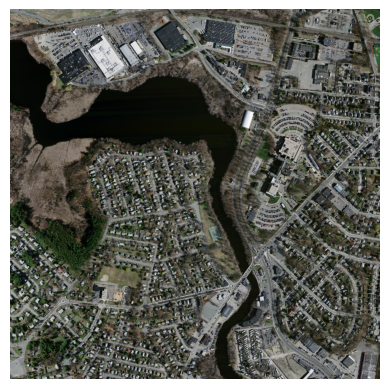

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import cv2
import os
from Vaizdas import Vaizdas
from IoU import IoU
import time

dataset_path = "./massachusetts-buildings-dataset"
test_image_path = f"{dataset_path}/png/train/22678915_15.png"
test_image_mask = f"{dataset_path}/png/train_labels/22678915_15.png"

test_image = Vaizdas(test_image_path, test_image_mask)
test_image2 = Vaizdas("./massachusetts-buildings-dataset/png/val/22978945_15.png", "./massachusetts-buildings-dataset/png/val_labels/22978945_15.png")

test_image.show()

Inference time: 0.24188590049743652 ms
Image shape: (1500, 1500)


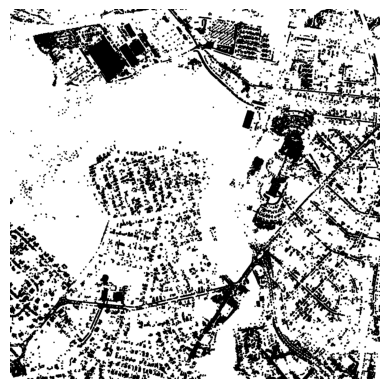

In [49]:
def thresholdSegment(image: Vaizdas) -> Vaizdas:
    threshold = image.gray < 160

    rgb_copy = image.rgb.copy()
    rgb_copy[threshold] = 0

    gray = cv2.cvtColor(rgb_copy, cv2.COLOR_RGB2GRAY)

    blurred = cv2.GaussianBlur(gray, (5,5), 0)

    mask = (blurred > 0).astype(np.uint8) * 255
    image.threshold_mask = mask

    return image

start = time.time()
temp = thresholdSegment(test_image)
print(f'Inference time: {time.time() - start} ms')

temp.show(temp.threshold_mask, cmap="Grays")

Inference time: 0.7598476409912109 ms
Image shape: (1500, 1500)


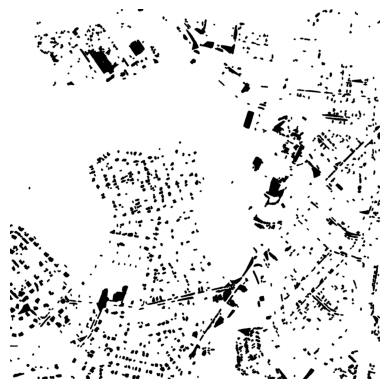

Image shape: (1500, 1500, 3)


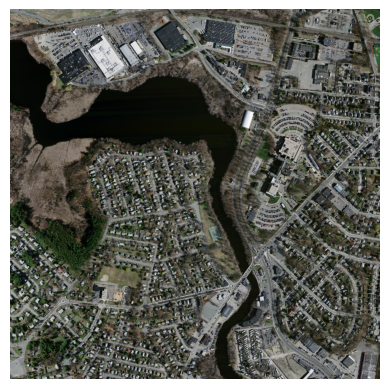

In [50]:
def mserSegment(image: Vaizdas) -> Vaizdas:
    
    mser = cv2.MSER_create(
    delta=5,              # it compares (sizei−sizei−delta)/sizei−delta
    min_area=10,           # prune the area which smaller than minArea 
    max_area=1500,        # prune the area which bigger than maxArea 
    max_variation=0.25,    # prune the area have similar size to its children 
    )

    threshold = image.gray < 160
    copy = image.gray.copy()
    copy = cv2.GaussianBlur(copy, (5,5), 0)
    copy[threshold] = 0

    regions, _ = mser.detectRegions(copy)

    mask = np.zeros_like(copy, dtype=np.uint8)

    cv2.drawContours(image=mask, 
                    contours=regions,
                    contourIdx=-1,
                    color=(255),
                    thickness=3)

    image.mser_mask = mask

    return image

start = time.time()
temp = mserSegment(test_image)
print(f'Inference time: {time.time() - start} ms')

temp.show(temp.mser_mask, cmap="Grays")
temp.show()


In [51]:
vaizdai = []
test_images = os.listdir(f'{dataset_path}/png/test')
for image in test_images:
    vaizdai.append(
        Vaizdas(f"{dataset_path}/png/test/{image}",
                f"{dataset_path}/png/test_labels/{image}")
    )

In [52]:
vaizdai = [thresholdSegment(v) for v in vaizdai]
vaizdai = [mserSegment(v) for v in vaizdai]

Mser segmentation IoU result: 0.18276546080372105
Image shape: (1500, 1500)


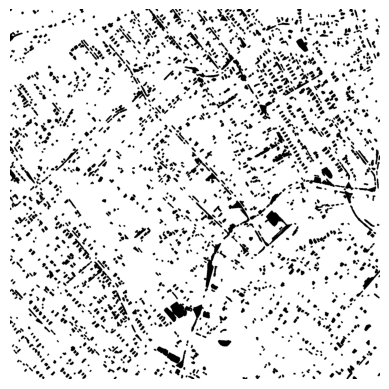

Image shape: (1500, 1500)


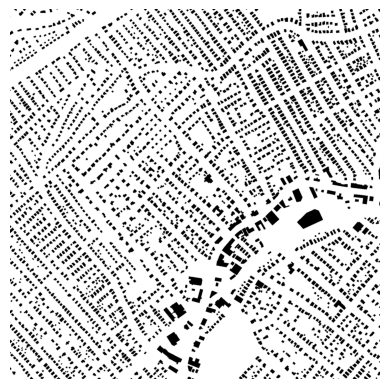

In [53]:
results = []
for img in vaizdai:
    iou = IoU(img.true_mask, img.mser_mask)
    results.append(iou.evaluate())

print(f'Mser segmentation IoU result: {np.average(results)}')

vaizdai[0].show(vaizdai[0].mser_mask, cmap="Grays")
vaizdai[0].show(vaizdai[0].true_mask, cmap="Grays")

Threshold segmentation IoU result: 0.2082946884799372
Image shape: (1500, 1500)


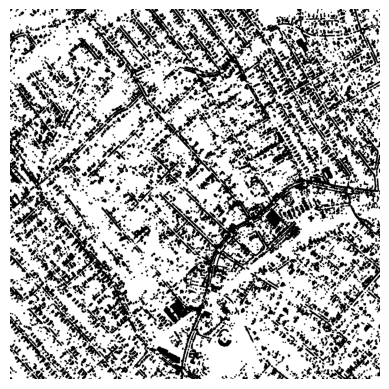

Image shape: (1500, 1500)


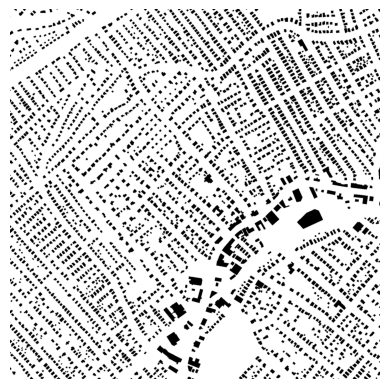

In [54]:
results = []
for img in vaizdai:
    iou = IoU(img.true_mask, img.threshold_mask)
    results.append(iou.evaluate())

print(f'Threshold segmentation IoU result: {np.average(results)}')

vaizdai[0].show(vaizdai[0].threshold_mask, cmap="Grays")
vaizdai[0].show(vaizdai[0].true_mask, cmap="Grays")